In [8]:
# Notebook 4: Expérimentations ML - Prédiction des temps de trajet

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("=== EXPÉRIMENTATIONS ML - PRÉDICTION TEMPS DE TRAJET - ML-TuniMapAi ===")
print()

=== EXPÉRIMENTATIONS ML - PRÉDICTION TEMPS DE TRAJET - ML-TuniMapAi ===



In [9]:
# 1. CHARGEMENT DES DONNÉES
print("1. CHARGEMENT DES DONNÉES")
print("-" * 60)

# Chargement des données préprocessées
delegations_df = pd.read_csv('../data/processed/tunisia_delegations_processed.csv')
ml_features = pd.read_csv('../data/processed/tunisia_ml_features.csv')

# Chargement des matrices de temps de trajet
with open('../data/processed/travel_matrices.pkl', 'rb') as f:
    matrices_data = pickle.load(f)

travel_times = matrices_data['travel_times']
car_travel_times = matrices_data['car_travel_times']
distance_matrix = matrices_data['distance_matrix']

print(f"Données chargées:")
print(f"- Points géographiques: {len(delegations_df)}")
print(f"- Features ML: {len(ml_features.columns)}")
print(f"- Modes de transport: {len(travel_times) + len(car_travel_times)}")
print()

1. CHARGEMENT DES DONNÉES
------------------------------------------------------------
Données chargées:
- Points géographiques: 4788
- Features ML: 25
- Modes de transport: 14



In [35]:
import os
import csv
from tqdm import tqdm
import numpy as np

def create_ml_dataset_batch(
    delegations_df, 
    distance_matrix, 
    travel_times, 
    car_travel_times, 
    output_csv="../data/processed/ml_dataset.csv",
    start_i=0,       # Reprendre à partir d'une ligne i
    batch_size=100   # Nombre d'origines à traiter par batch
):
    """
    Crée le dataset ML en batch pour éviter MemoryError.
    Permet de reprendre depuis un index start_i.
    """
    n_points = len(delegations_df)
    
    # Colonnes
    origin_cols = [
        'origin_lat','origin_lon','origin_accessibility','origin_tourism','origin_landscape',
        'origin_cultural','origin_cluster','origin_zone_type','origin_governorate',
        'origin_has_bus','origin_has_metro','origin_has_train','origin_has_taxi'
    ]
    dest_cols = [
        'dest_lat','dest_lon','dest_accessibility','dest_tourism','dest_landscape',
        'dest_cultural','dest_cluster','dest_zone_type','dest_governorate',
        'dest_has_bus','dest_has_metro','dest_has_train','dest_has_taxi'
    ]
    trip_cols = ['distance_km','same_governorate','same_cluster','tourism_diff','accessibility_diff']
    
    time_cols = [f"time_{mode}" for mode in travel_times.keys()] + [f"time_{car}" for car in car_travel_times.keys()]
    
    all_columns = origin_cols + dest_cols + trip_cols + time_cols

    # Ouvrir le CSV en mode append
    write_header = not os.path.exists(output_csv) or start_i == 0
    f = open(output_csv, "a", newline="", encoding="utf-8")
    writer = csv.DictWriter(f, fieldnames=all_columns)
    if write_header:
        writer.writeheader()
    
    print(f"Création du dataset ML en batch à partir de i={start_i}...")

    for i in tqdm(range(start_i, n_points)):
        origin = delegations_df.iloc[i]
        origin_features = {
            'origin_lat': origin['Latitude'],
            'origin_lon': origin['Longitude'],
            'origin_accessibility': origin['accessibility_score'],
            'origin_tourism': origin['tourism_score'],
            'origin_landscape': origin['landscape_beauty_score'],
            'origin_cultural': origin['cultural_interest_score'],
            'origin_cluster': origin['cluster_id'],
            'origin_zone_type': origin['zone_type_encoded'],
            'origin_governorate': origin['Governorate_encoded'],
            'origin_has_bus': origin['has_bus_station'],
            'origin_has_metro': origin['has_metro_station'],
            'origin_has_train': origin['has_train_station'],
            'origin_has_taxi': origin['has_taxi_station']
        }
        
        batch_rows = []
        for j in range(n_points):
            if i == j:
                continue
            dest = delegations_df.iloc[j]
            dest_features = {
                'dest_lat': dest['Latitude'],
                'dest_lon': dest['Longitude'],
                'dest_accessibility': dest['accessibility_score'],
                'dest_tourism': dest['tourism_score'],
                'dest_landscape': dest['landscape_beauty_score'],
                'dest_cultural': dest['cultural_interest_score'],
                'dest_cluster': dest['cluster_id'],
                'dest_zone_type': dest['zone_type_encoded'],
                'dest_governorate': dest['Governorate_encoded'],
                'dest_has_bus': dest['has_bus_station'],
                'dest_has_metro': dest['has_metro_station'],
                'dest_has_train': dest['has_train_station'],
                'dest_has_taxi': dest['has_taxi_station']
            }
            trip_features = {
                'distance_km': distance_matrix[i, j],
                'same_governorate': int(origin['Governorate'] == dest['Governorate']),
                'same_cluster': int(origin['cluster_id'] == dest['cluster_id']),
                'tourism_diff': abs(origin['tourism_score'] - dest['tourism_score']),
                'accessibility_diff': abs(origin['accessibility_score'] - dest['accessibility_score'])
            }
            row = {**origin_features, **dest_features, **trip_features}
            
            for mode, times in travel_times.items():
                row[f"time_{mode}"] = times[i, j] if np.isfinite(times[i, j]) else None
            for car_type, times in car_travel_times.items():
                row[f"time_{car_type}"] = times[i, j] if np.isfinite(times[i, j]) else None
            
            writer.writerow(row)
        
        # Break pour batch_size
        if (i - start_i + 1) % batch_size == 0:
            print(f"✅ Batch terminé jusqu'à i={i}. Vous pouvez reprendre à i={i+1} plus tard.")
            break

    f.close()
    print("✅ Batch ML écrit dans", output_csv)

In [39]:
batch_size = 100  # Ajuste selon ta RAM
start_i = 0
output_csv = "../data/processed/ml_dataset.csv"

# Supprime le CSV existant pour éviter l'accumulation
import os
if os.path.exists(output_csv):
    os.remove(output_csv)

# Boucle automatique pour traiter tous les points
n_points = len(delegations_df)
while start_i < n_points:
    print(f"Traitement du batch {start_i} à {min(start_i + batch_size, n_points) - 1}")
    
    create_ml_dataset_batch(
        delegations_df,
        distance_matrix,
        travel_times,
        car_travel_times,
        output_csv=output_csv,
        start_i=start_i,
        batch_size=batch_size
    )
    
    start_i += batch_size

print(f"✅ Dataset ML complet généré dans {output_csv}")


Traitement du batch 0 à 99
Création du dataset ML en batch à partir de i=0...


  2%|▏         | 99/4788 [01:50<1:27:10,  1.12s/it]


✅ Batch terminé jusqu'à i=99. Vous pouvez reprendre à i=100 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 100 à 199
Création du dataset ML en batch à partir de i=100...


  2%|▏         | 99/4688 [01:52<1:26:32,  1.13s/it]


✅ Batch terminé jusqu'à i=199. Vous pouvez reprendre à i=200 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 200 à 299
Création du dataset ML en batch à partir de i=200...


  2%|▏         | 99/4588 [01:48<1:22:08,  1.10s/it]


✅ Batch terminé jusqu'à i=299. Vous pouvez reprendre à i=300 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 300 à 399
Création du dataset ML en batch à partir de i=300...


  2%|▏         | 99/4488 [01:44<1:17:24,  1.06s/it]


✅ Batch terminé jusqu'à i=399. Vous pouvez reprendre à i=400 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 400 à 499
Création du dataset ML en batch à partir de i=400...


  2%|▏         | 99/4388 [01:47<1:17:42,  1.09s/it]


✅ Batch terminé jusqu'à i=499. Vous pouvez reprendre à i=500 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 500 à 599
Création du dataset ML en batch à partir de i=500...


  2%|▏         | 99/4288 [01:50<1:18:01,  1.12s/it]


✅ Batch terminé jusqu'à i=599. Vous pouvez reprendre à i=600 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 600 à 699
Création du dataset ML en batch à partir de i=600...


  2%|▏         | 99/4188 [01:57<1:20:58,  1.19s/it]


✅ Batch terminé jusqu'à i=699. Vous pouvez reprendre à i=700 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 700 à 799
Création du dataset ML en batch à partir de i=700...


  2%|▏         | 99/4088 [01:52<1:15:24,  1.13s/it]


✅ Batch terminé jusqu'à i=799. Vous pouvez reprendre à i=800 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 800 à 899
Création du dataset ML en batch à partir de i=800...


  2%|▏         | 99/3988 [01:45<1:09:21,  1.07s/it]


✅ Batch terminé jusqu'à i=899. Vous pouvez reprendre à i=900 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 900 à 999
Création du dataset ML en batch à partir de i=900...


  3%|▎         | 99/3888 [01:47<1:08:35,  1.09s/it]


✅ Batch terminé jusqu'à i=999. Vous pouvez reprendre à i=1000 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1000 à 1099
Création du dataset ML en batch à partir de i=1000...


  3%|▎         | 99/3788 [01:46<1:05:52,  1.07s/it]


✅ Batch terminé jusqu'à i=1099. Vous pouvez reprendre à i=1100 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1100 à 1199
Création du dataset ML en batch à partir de i=1100...


  3%|▎         | 99/3688 [01:42<1:01:45,  1.03s/it]


✅ Batch terminé jusqu'à i=1199. Vous pouvez reprendre à i=1200 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1200 à 1299
Création du dataset ML en batch à partir de i=1200...


  3%|▎         | 99/3588 [01:41<59:44,  1.03s/it]  


✅ Batch terminé jusqu'à i=1299. Vous pouvez reprendre à i=1300 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1300 à 1399
Création du dataset ML en batch à partir de i=1300...


  3%|▎         | 99/3488 [01:40<57:16,  1.01s/it]  


✅ Batch terminé jusqu'à i=1399. Vous pouvez reprendre à i=1400 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1400 à 1499
Création du dataset ML en batch à partir de i=1400...


  3%|▎         | 99/3388 [01:43<57:09,  1.04s/it]  


✅ Batch terminé jusqu'à i=1499. Vous pouvez reprendre à i=1500 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1500 à 1599
Création du dataset ML en batch à partir de i=1500...


  3%|▎         | 99/3288 [01:45<56:23,  1.06s/it]  


✅ Batch terminé jusqu'à i=1599. Vous pouvez reprendre à i=1600 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1600 à 1699
Création du dataset ML en batch à partir de i=1600...


  3%|▎         | 99/3188 [01:41<52:52,  1.03s/it]  


✅ Batch terminé jusqu'à i=1699. Vous pouvez reprendre à i=1700 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1700 à 1799
Création du dataset ML en batch à partir de i=1700...


  3%|▎         | 99/3088 [01:45<53:20,  1.07s/it]  


✅ Batch terminé jusqu'à i=1799. Vous pouvez reprendre à i=1800 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1800 à 1899
Création du dataset ML en batch à partir de i=1800...


  3%|▎         | 99/2988 [01:45<51:07,  1.06s/it]  


✅ Batch terminé jusqu'à i=1899. Vous pouvez reprendre à i=1900 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 1900 à 1999
Création du dataset ML en batch à partir de i=1900...


  3%|▎         | 99/2888 [01:43<48:43,  1.05s/it]


✅ Batch terminé jusqu'à i=1999. Vous pouvez reprendre à i=2000 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2000 à 2099
Création du dataset ML en batch à partir de i=2000...


  4%|▎         | 99/2788 [01:41<45:47,  1.02s/it] 


✅ Batch terminé jusqu'à i=2099. Vous pouvez reprendre à i=2100 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2100 à 2199
Création du dataset ML en batch à partir de i=2100...


  4%|▎         | 99/2688 [01:48<47:09,  1.09s/it]  


✅ Batch terminé jusqu'à i=2199. Vous pouvez reprendre à i=2200 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2200 à 2299
Création du dataset ML en batch à partir de i=2200...


  4%|▍         | 99/2588 [01:46<44:47,  1.08s/it]


✅ Batch terminé jusqu'à i=2299. Vous pouvez reprendre à i=2300 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2300 à 2399
Création du dataset ML en batch à partir de i=2300...


  4%|▍         | 99/2488 [01:43<41:39,  1.05s/it] 


✅ Batch terminé jusqu'à i=2399. Vous pouvez reprendre à i=2400 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2400 à 2499
Création du dataset ML en batch à partir de i=2400...


  4%|▍         | 99/2388 [01:43<39:56,  1.05s/it]


✅ Batch terminé jusqu'à i=2499. Vous pouvez reprendre à i=2500 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2500 à 2599
Création du dataset ML en batch à partir de i=2500...


  4%|▍         | 99/2288 [01:45<38:58,  1.07s/it]


✅ Batch terminé jusqu'à i=2599. Vous pouvez reprendre à i=2600 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2600 à 2699
Création du dataset ML en batch à partir de i=2600...


  5%|▍         | 99/2188 [01:40<35:19,  1.01s/it]


✅ Batch terminé jusqu'à i=2699. Vous pouvez reprendre à i=2700 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2700 à 2799
Création du dataset ML en batch à partir de i=2700...


  5%|▍         | 99/2088 [01:42<34:23,  1.04s/it]


✅ Batch terminé jusqu'à i=2799. Vous pouvez reprendre à i=2800 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2800 à 2899
Création du dataset ML en batch à partir de i=2800...


  5%|▍         | 99/1988 [01:44<33:12,  1.05s/it]


✅ Batch terminé jusqu'à i=2899. Vous pouvez reprendre à i=2900 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 2900 à 2999
Création du dataset ML en batch à partir de i=2900...


  5%|▌         | 99/1888 [01:45<31:39,  1.06s/it]


✅ Batch terminé jusqu'à i=2999. Vous pouvez reprendre à i=3000 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3000 à 3099
Création du dataset ML en batch à partir de i=3000...


  6%|▌         | 99/1788 [01:44<29:46,  1.06s/it]


✅ Batch terminé jusqu'à i=3099. Vous pouvez reprendre à i=3100 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3100 à 3199
Création du dataset ML en batch à partir de i=3100...


  6%|▌         | 99/1688 [01:54<30:39,  1.16s/it]


✅ Batch terminé jusqu'à i=3199. Vous pouvez reprendre à i=3200 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3200 à 3299
Création du dataset ML en batch à partir de i=3200...


  6%|▌         | 99/1588 [01:52<28:18,  1.14s/it]


✅ Batch terminé jusqu'à i=3299. Vous pouvez reprendre à i=3300 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3300 à 3399
Création du dataset ML en batch à partir de i=3300...


  7%|▋         | 99/1488 [01:43<24:07,  1.04s/it]


✅ Batch terminé jusqu'à i=3399. Vous pouvez reprendre à i=3400 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3400 à 3499
Création du dataset ML en batch à partir de i=3400...


  7%|▋         | 99/1388 [01:43<22:23,  1.04s/it]


✅ Batch terminé jusqu'à i=3499. Vous pouvez reprendre à i=3500 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3500 à 3599
Création du dataset ML en batch à partir de i=3500...


  8%|▊         | 99/1288 [01:46<21:18,  1.08s/it]


✅ Batch terminé jusqu'à i=3599. Vous pouvez reprendre à i=3600 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3600 à 3699
Création du dataset ML en batch à partir de i=3600...


  8%|▊         | 99/1188 [01:43<19:01,  1.05s/it]


✅ Batch terminé jusqu'à i=3699. Vous pouvez reprendre à i=3700 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3700 à 3799
Création du dataset ML en batch à partir de i=3700...


  9%|▉         | 99/1088 [01:44<17:21,  1.05s/it]


✅ Batch terminé jusqu'à i=3799. Vous pouvez reprendre à i=3800 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3800 à 3899
Création du dataset ML en batch à partir de i=3800...


 10%|█         | 99/988 [01:46<15:52,  1.07s/it]


✅ Batch terminé jusqu'à i=3899. Vous pouvez reprendre à i=3900 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 3900 à 3999
Création du dataset ML en batch à partir de i=3900...


 11%|█         | 99/888 [01:51<14:48,  1.13s/it]


✅ Batch terminé jusqu'à i=3999. Vous pouvez reprendre à i=4000 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4000 à 4099
Création du dataset ML en batch à partir de i=4000...


 13%|█▎        | 99/788 [01:52<13:06,  1.14s/it]


✅ Batch terminé jusqu'à i=4099. Vous pouvez reprendre à i=4100 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4100 à 4199
Création du dataset ML en batch à partir de i=4100...


 14%|█▍        | 99/688 [01:52<11:06,  1.13s/it]


✅ Batch terminé jusqu'à i=4199. Vous pouvez reprendre à i=4200 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4200 à 4299
Création du dataset ML en batch à partir de i=4200...


 17%|█▋        | 99/588 [01:52<09:15,  1.14s/it]


✅ Batch terminé jusqu'à i=4299. Vous pouvez reprendre à i=4300 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4300 à 4399
Création du dataset ML en batch à partir de i=4300...


 20%|██        | 99/488 [01:49<07:11,  1.11s/it]


✅ Batch terminé jusqu'à i=4399. Vous pouvez reprendre à i=4400 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4400 à 4499
Création du dataset ML en batch à partir de i=4400...


 26%|██▌       | 99/388 [01:48<05:15,  1.09s/it]


✅ Batch terminé jusqu'à i=4499. Vous pouvez reprendre à i=4500 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4500 à 4599
Création du dataset ML en batch à partir de i=4500...


 34%|███▍      | 99/288 [01:51<03:33,  1.13s/it]


✅ Batch terminé jusqu'à i=4599. Vous pouvez reprendre à i=4600 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4600 à 4699
Création du dataset ML en batch à partir de i=4600...


 53%|█████▎    | 99/188 [01:50<01:39,  1.12s/it]


✅ Batch terminé jusqu'à i=4699. Vous pouvez reprendre à i=4700 plus tard.
✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
Traitement du batch 4700 à 4787
Création du dataset ML en batch à partir de i=4700...


100%|██████████| 88/88 [01:36<00:00,  1.10s/it]

✅ Batch ML écrit dans ../data/processed/ml_dataset.csv
✅ Dataset ML complet généré dans ../data/processed/ml_dataset.csv


In [3]:
import pandas as pd

ml_dataset = pd.read_csv("../data/processed/ml_dataset.csv")
print(f"Dataset chargé: {len(ml_dataset)} lignes")

Dataset chargé: 22920156 lignes


In [4]:
# 3. ANALYSE ET NETTOYAGE DU DATASET
print("3. ANALYSE ET NETTOYAGE DU DATASET")
print("-" * 60)

# Statistiques des valeurs manquantes
missing_stats = ml_dataset.isnull().sum()
missing_targets = missing_stats[missing_stats.index.str.startswith('time_')].sort_values(ascending=False)

print("Valeurs manquantes par mode de transport:")
for mode, count in missing_targets.items():
    percentage = (count / len(ml_dataset)) * 100
    print(f"- {mode}: {count} ({percentage:.1f}%)")

print()

# Suppression des lignes sans aucun temps de trajet valide
time_columns = [col for col in ml_dataset.columns if col.startswith('time_')]
ml_dataset = ml_dataset.dropna(subset=['distance_km'])  # Distance est obligatoire
initial_size = len(ml_dataset)

# Garder seulement les lignes avec au moins un temps valide
ml_dataset = ml_dataset[ml_dataset[time_columns].notna().any(axis=1)]
print(f"Dataset nettoyé: {len(ml_dataset)} échantillons (supprimé: {initial_size - len(ml_dataset)})")

3. ANALYSE ET NETTOYAGE DU DATASET
------------------------------------------------------------


Valeurs manquantes par mode de transport:
- time_metro: 22822950 (99.6%)
- time_walking: 22746296 (99.2%)
- time_train: 22543930 (98.4%)
- time_bike: 22161016 (96.7%)
- time_bus: 20276892 (88.5%)
- time_taxi: 16839922 (73.5%)
- time_car_city: 12509176 (54.6%)
- time_economy_60hp: 12509176 (54.6%)
- time_standard_90hp: 12509176 (54.6%)
- time_mid_120hp: 12509176 (54.6%)
- time_premium_150hp: 12509176 (54.6%)
- time_sport_200hp: 12509176 (54.6%)
- time_luxury_300hp: 12509176 (54.6%)
- time_car_highway: 71320 (0.3%)

Dataset nettoyé: 22848836 échantillons (supprimé: 71320)


In [3]:
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

# XGBoost
import xgboost as xgb

In [4]:
ml_dataset = pd.read_csv("../data/processed/ml_dataset.csv")

In [5]:
# 4. PRÉPARATION DES MODÈLES ML
print("\n4. PRÉPARATION DES MODÈLES ML")
print("-" * 60)

# Définition des features d'entrée
feature_columns = [col for col in ml_dataset.columns if not col.startswith('time_')]
print(f"Features d'entrée: {len(feature_columns)}")

# ⚡️ Modèles à tester (seulement ceux qui passent à l'échelle)
models = {
    'Linear Regression': LinearRegression(n_jobs=-1),
    'Ridge Regression': Ridge(alpha=1.0),
    'XGBoost (hist)': xgb.XGBRegressor(
        n_estimators=200,
        max_depth=8,
        learning_rate=0.1,
        tree_method="hist",  # mode rapide et mémoire réduite
        n_jobs=-1,
        random_state=42
    ),
    # éventuellement LightGBM si installé :
    # 'LightGBM': lgb.LGBMRegressor(
    #     n_estimators=200, learning_rate=0.1,
    #     num_leaves=64, random_state=42, n_jobs=-1
    # )
}

print(f"Modèles à tester: {list(models.keys())}")



4. PRÉPARATION DES MODÈLES ML
------------------------------------------------------------
Features d'entrée: 31
Modèles à tester: ['Linear Regression', 'Ridge Regression', 'XGBoost (hist)']


In [6]:
# 5. ENTRAÎNEMENT ET ÉVALUATION POUR VOITURE STANDARD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
import xgboost as xgb
from tqdm import tqdm
import numpy as np

print("\n5. ENTRAÎNEMENT POUR VOITURE STANDARD (90HP)")
print("-" * 60)

target = 'time_standard_90hp'

# Filtrage des données avec target valide
train_data = ml_dataset[ml_dataset[target].notna()].copy()
print(f"Échantillons valides pour {target}: {len(train_data)}")

if len(train_data) > 100:
    X = train_data[feature_columns]
    y = train_data[target]

    # Division train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Normalisation des features pour modèles linéaires
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ⚡️ Modèles adaptés aux grands volumes
    models = {
        "Linear Regression": LinearRegression(n_jobs=-1),
        "Ridge Regression": Ridge(alpha=1.0),
        "XGBoost (hist)": xgb.XGBRegressor(
            n_estimators=200,
            max_depth=8,
            learning_rate=0.1,
            tree_method="hist",    # super rapide & peu gourmand
            n_jobs=-1,
            random_state=42,
        ),
    }

    results = {}
    print("Entraînement et évaluation des modèles:")

    for name, model in tqdm(models.items()):
        try:
            if name.startswith("Linear") or name.startswith("Ridge"):
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            else:  # XGBoost
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            results[name] = {
                "MAE": mae,
                "RMSE": rmse,
                "R2": r2,
                "model": model,
            }

            print(f"  {name}: MAE={mae:.3f}h, RMSE={rmse:.3f}h, R2={r2:.3f}")

        except Exception as e:
            print(f"  {name}: Erreur - {e}")

    best_model_name = min(results.keys(), key=lambda x: results[x]["MAE"])
    best_model = results[best_model_name]

    print(f"\nMeilleur modèle: {best_model_name}")
    print(
        f"Performance: MAE={best_model['MAE']:.3f}h, R2={best_model['R2']:.3f}"
    )

else:
    print(f"Pas assez de données pour l'entraînement ({len(train_data)} échantillons)")
    best_model_name = None

print()



5. ENTRAÎNEMENT POUR VOITURE STANDARD (90HP)
------------------------------------------------------------
Échantillons valides pour time_standard_90hp: 10410980
Entraînement et évaluation des modèles:


 33%|███▎      | 1/3 [00:16<00:32, 16.41s/it]

  Linear Regression: MAE=0.156h, RMSE=0.206h, R2=0.984


 67%|██████▋   | 2/3 [00:20<00:09,  9.30s/it]

  Ridge Regression: MAE=0.156h, RMSE=0.206h, R2=0.984


100%|██████████| 3/3 [03:12<00:00, 64.33s/it]

  XGBoost (hist): MAE=0.154h, RMSE=0.203h, R2=0.984

Meilleur modèle: XGBoost (hist)
Performance: MAE=0.154h, R2=0.984



6. ANALYSE DES FEATURES IMPORTANTES
------------------------------------------------------------
Top 10 features importantes:
               feature  importance
26         distance_km    0.999070
21    dest_governorate    0.000044
8   origin_governorate    0.000044
24      dest_has_train    0.000033
17      dest_landscape    0.000032
18       dest_cultural    0.000032
29        tourism_diff    0.000031
4     origin_landscape    0.000031
5      origin_cultural    0.000031
16        dest_tourism    0.000031


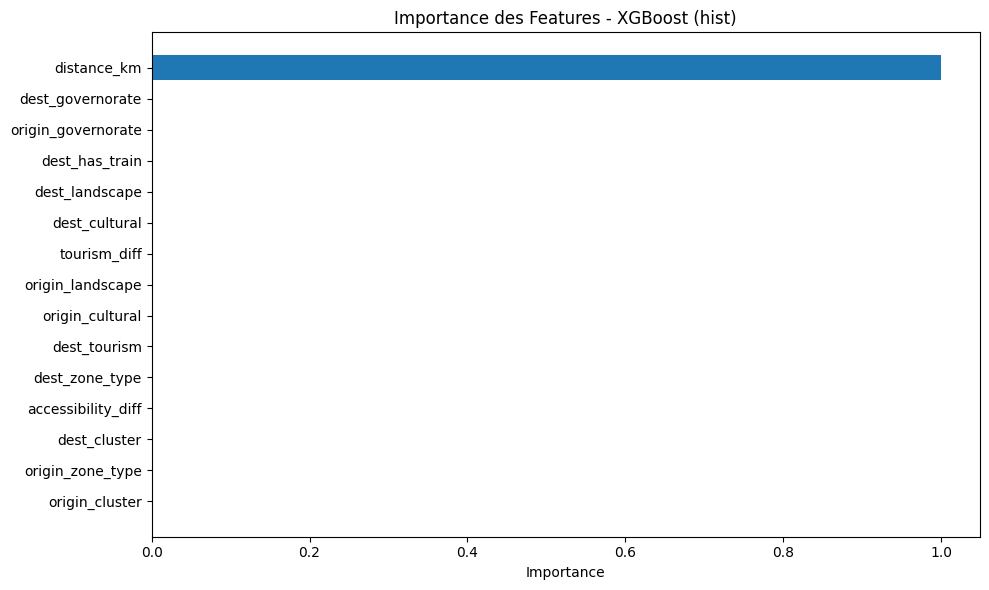

In [7]:
# 6. ANALYSE DES FEATURES IMPORTANTES
if best_model_name and any(name in best_model_name for name in ['XGBoost', 'LightGBM']):
    print("6. ANALYSE DES FEATURES IMPORTANTES")
    print("-" * 60)
    
    model = results[best_model_name]['model']
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({
            'feature': feature_columns,
            'importance': importances
        }).sort_values('importance', ascending=False)
        
        print("Top 10 features importantes:")
        print(feature_importance.head(10))
        
        # Visualisation
        import matplotlib.pyplot as plt
        plt.figure(figsize=(10, 6))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importance')
        plt.title(f'Importance des Features - {best_model_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

print()

In [8]:
# construire la liste des colonnes "temps"
time_columns = [col for col in ml_dataset.columns if col.startswith('time_')]
print(f"Colonnes de temps: {len(time_columns)}")


Colonnes de temps: 14


In [9]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import gc
import time

# Initialize storage
transport_models = {}
transport_results = {}

# Get time columns
time_columns = [col for col in ml_dataset.columns if col.startswith("time_")]
print(f"Found {len(time_columns)} time columns")

# Quick check of data availability
print("Checking data availability...")
modes_to_train = []

for col in time_columns:
    valid_count = ml_dataset[col].notna().sum()  # Fast count without chunks
    if valid_count > 200:
        modes_to_train.append(col)
        print(f"  {col}: {valid_count:,} samples")

print(f"\nWill train {len(modes_to_train)} modes\n")

# Training parameters
max_samples_per_mode = 500_000  # Limit training samples for speed
batch_size = 50_000  # Larger batches for speed
outlier_min, outlier_max = 0.01, 24
max_log_value = 3.5  # log(e^3.5) ≈ 33 hours

def get_data_stats(mode_data, mode_name):
    """Get robust statistics for a mode"""
    valid = mode_data[(mode_data >= outlier_min) & (mode_data <= outlier_max)].dropna()
    
    if len(valid) < 100:
        return None
    
    # Sample for stats if too large
    if len(valid) > 50000:
        valid = valid.sample(50000, random_state=42)
    
    median_val = valid.median()
    q25, q75 = valid.quantile([0.25, 0.75])
    iqr = q75 - q25
    
    # Adaptive bounds based on IQR
    lower_bound = max(outlier_min, q25 - 3 * iqr)
    upper_bound = min(outlier_max, q75 + 3 * iqr)
    
    return {
        'median': median_val,
        'q25': q25,
        'q75': q75,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

def sample_training_data(dataset, mode, feature_cols, stats, max_samples):
    """Efficiently sample training data"""
    n_rows = len(dataset)
    
    # If dataset is small, use all data
    if n_rows <= max_samples:
        data = dataset[[mode] + feature_cols].copy()
        valid_mask = (
            data[mode].notna() &
            (data[mode] >= stats['lower_bound']) &
            (data[mode] <= stats['upper_bound'])
        )
        if valid_mask.sum() == 0:
            return None, None
        
        X = data.loc[valid_mask, feature_cols].astype(np.float32).values
        y = np.log1p(data.loc[valid_mask, mode].astype(np.float32).values)
        y = np.clip(y, -2, max_log_value)
        
        return X, y
    
    # For large datasets, sample strategically
    # Sample from different parts of dataset
    sample_indices = []
    samples_per_segment = max_samples // 10
    
    for i in range(10):
        start = int(i * n_rows / 10)
        end = int((i + 1) * n_rows / 10)
        segment_size = end - start
        
        if segment_size > samples_per_segment:
            indices = np.random.choice(
                range(start, end),
                samples_per_segment,
                replace=False
            )
        else:
            indices = range(start, end)
        
        sample_indices.extend(indices)
    
    # Get sampled data
    data = dataset.iloc[sample_indices][[mode] + feature_cols].copy()
    
    valid_mask = (
        data[mode].notna() &
        (data[mode] >= stats['lower_bound']) &
        (data[mode] <= stats['upper_bound'])
    )
    
    if valid_mask.sum() == 0:
        return None, None
    
    X = data.loc[valid_mask, feature_cols].astype(np.float32).values
    y = np.log1p(data.loc[valid_mask, mode].astype(np.float32).values)
    y = np.clip(y, -2, max_log_value)
    
    return X, y

# Train each mode
for mode_idx, mode in enumerate(modes_to_train):
    print(f"[{mode_idx+1}/{len(modes_to_train)}] Training {mode}...")
    start_time = time.time()
    
    try:
        # Get data statistics
        print("  Analyzing data...")
        stats = get_data_stats(ml_dataset[mode], mode)
        
        if stats is None:
            print(f"  Insufficient valid data")
            continue
        
        print(f"  Median: {stats['median']:.2f}h, IQR: [{stats['q25']:.2f}, {stats['q75']:.2f}]")
        print(f"  Bounds: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}] hours")
        
        # Sample training data efficiently
        print(f"  Sampling training data (max {max_samples_per_mode:,})...")
        X_train, y_train = sample_training_data(
            ml_dataset, mode, feature_columns, stats, max_samples_per_mode
        )
        
        if X_train is None or len(X_train) < 100:
            print(f"  Insufficient training samples")
            continue
        
        print(f"  Training on {len(X_train):,} samples...")
        
        # Split into train and validation
        n_train = int(len(X_train) * 0.9)
        indices = np.random.permutation(len(X_train))
        train_idx = indices[:n_train]
        val_idx = indices[n_train:]
        
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_val, y_val = X_train[val_idx], y_train[val_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr)
        X_val_scaled = scaler.transform(X_val)
        
        # Train model with mini-batch SGD
        model = SGDRegressor(
            max_iter=1,
            tol=None,
            learning_rate='invscaling',
            eta0=0.01,
            power_t=0.25,
            random_state=42,
            penalty='l2',
            alpha=0.001,  # Stronger regularization
            warm_start=True
        )
        
        # Train in multiple passes with early stopping
        best_val_score = -np.inf
        patience = 3
        patience_counter = 0
        n_passes = 10
        
        mini_batch_size = min(10000, len(X_tr))
        
        for pass_num in range(n_passes):
            # Shuffle and train
            shuffle_idx = np.random.permutation(len(X_tr))
            
            for i in range(0, len(X_tr), mini_batch_size):
                batch_idx = shuffle_idx[i:i + mini_batch_size]
                model.partial_fit(X_tr_scaled[batch_idx], y_tr[batch_idx])
            
            # Validate
            y_pred_log = model.predict(X_val_scaled)
            y_pred_log = np.clip(y_pred_log, -2, max_log_value)
            y_pred = np.expm1(y_pred_log)
            y_val_real = np.expm1(y_val)
            
            val_r2 = r2_score(y_val_real, y_pred)
            
            if val_r2 > best_val_score:
                best_val_score = val_r2
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"    Early stopping at pass {pass_num + 1}")
                break
        
        # Final evaluation
        y_pred_log = model.predict(X_val_scaled)
        y_pred_log = np.clip(y_pred_log, -2, max_log_value)
        y_pred = np.expm1(y_pred_log)
        y_pred = np.clip(y_pred, 0, stats['upper_bound'] * 2)
        
        y_val_real = np.expm1(y_val)
        
        mae = mean_absolute_error(y_val_real, y_pred)
        r2 = r2_score(y_val_real, y_pred)
        median_error = np.median(np.abs(y_val_real - y_pred))
        within_30min = np.mean(np.abs(y_val_real - y_pred) < 0.5) * 100
        
        elapsed = time.time() - start_time
        
        print(f"  MAE: {mae:.3f}h | R²: {r2:.3f} | Median: {median_error:.3f}h | <30min: {within_30min:.1f}%")
        print(f"  Completed in {elapsed:.1f}s")
        
        # Store results
        transport_models[mode] = {
            "model": model,
            "scaler": scaler,
            "bounds": (stats['lower_bound'], stats['upper_bound']),
            "max_log": max_log_value,
            "stats": stats
        }
        
        transport_results[mode] = {
            "MAE": mae,
            "R2": r2,
            "median_error": median_error,
            "within_30min": within_30min,
            "train_samples": len(X_tr),
            "val_samples": len(X_val),
            "data_median": stats['median'],
            "training_time": elapsed
        }
        
        # Clean up
        del X_train, y_train, X_tr, y_tr, X_val, y_val
        del X_tr_scaled, X_val_scaled, y_pred, y_pred_log, y_val_real
        gc.collect()
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        import traceback
        traceback.print_exc()
        continue
    
    print()

# Print summary
print("=" * 85)
print("TRAINING SUMMARY")
print("=" * 85)
print(f"{'Mode':<25} {'MAE':<8} {'R²':<8} {'Median':<8} {'<30min':<8} {'Samples':<10}")
print("-" * 85)

successful = 0
for mode in modes_to_train:
    if mode in transport_results:
        r = transport_results[mode]
        mae = r.get('MAE', 0)
        r2 = r.get('R2', 0)
        med = r.get('median_error', 0)
        acc = r.get('within_30min', 0)
        samp = r.get('train_samples', 0)
        
        status = "✓" if r2 > 0.3 else "⚠" if r2 > 0 else "✗"
        
        print(f"{status} {mode:<23} {mae:6.2f}h  {r2:7.3f}  {med:6.2f}h  {acc:5.1f}%  {samp:8,}")
        
        if r2 > 0:
            successful += 1

print("=" * 85)
print(f"Models with R² > 0: {successful}/{len(modes_to_train)}")
print(f"Total training time: {sum(r.get('training_time', 0) for r in transport_results.values()):.1f}s")

# Safe prediction function
def predict_time_safe(mode, X_features):
    """Make safe predictions"""
    if mode not in transport_models:
        return None
    
    info = transport_models[mode]
    
    X_scaled = info['scaler'].transform(X_features)
    y_pred_log = info['model'].predict(X_scaled)
    y_pred_log = np.clip(y_pred_log, -2, info['max_log'])
    y_pred = np.expm1(y_pred_log)
    
    lower, upper = info['bounds']
    y_pred = np.clip(y_pred, 0, upper * 2)
    
    return y_pred

print("\nUse predict_time_safe(mode, X_features) for predictions")

Found 14 time columns
Checking data availability...
  time_walking: 173,860 samples
  time_bike: 759,140 samples
  time_bus: 2,643,264 samples
  time_metro: 97,206 samples
  time_train: 376,226 samples
  time_taxi: 6,080,234 samples
  time_car_city: 10,410,980 samples
  time_car_highway: 22,848,836 samples
  time_economy_60hp: 10,410,980 samples
  time_standard_90hp: 10,410,980 samples
  time_mid_120hp: 10,410,980 samples
  time_premium_150hp: 10,410,980 samples
  time_sport_200hp: 10,410,980 samples
  time_luxury_300hp: 10,410,980 samples

Will train 14 modes

[1/14] Training time_walking...
  Analyzing data...
  Median: 0.57h, IQR: [0.31, 0.81]
  Bounds: [0.01, 2.30] hours
  Sampling training data (max 500,000)...
  Training on 1,866 samples...
    Early stopping at pass 10
  MAE: 0.121h | R²: 0.754 | Median: 0.077h | <30min: 100.0%
  Completed in 82.5s

[2/14] Training time_bike...
  Analyzing data...
  Median: 0.69h, IQR: [0.35, 0.99]
  Bounds: [0.01, 2.93] hours
  Sampling trainin

In [10]:
# 8. FONCTION DE PRÉDICTION UNIVERSELLE
print("\n8. FONCTION DE PRÉDICTION UNIVERSELLE")
print("-" * 60)

def predict_travel_time(origin_features, dest_features, transport_mode, car_horsepower=90):
    """
    Prédit le temps de trajet entre deux points

    Args:
        origin_features: dict avec les caractéristiques de l'origine
        dest_features: dict avec les caractéristiques de la destination  
        transport_mode: str, mode de transport
        car_horsepower: int, puissance pour les voitures

    Returns:
        dict avec prédiction et informations
    """

    # Mappage chevaux → type de voiture
    hp_to_car_type = {
        60: 'economy_60hp',
        90: 'standard_90hp', 
        120: 'mid_120hp',
        150: 'premium_150hp',
        200: 'sport_200hp',
        300: 'luxury_300hp'
    }

    # Déterminer le mode cible
    if transport_mode == 'car':
        closest_hp = min(hp_to_car_type.keys(), key=lambda x: abs(x - car_horsepower))
        target_mode = f'time_{hp_to_car_type[closest_hp]}'
    else:
        target_mode = f'time_{transport_mode}'

    # Vérifier si on a un modèle pour ce mode
    if target_mode not in transport_models:
        return {
            'prediction_hours': None,
            'error': f"Aucun modèle disponible pour {transport_mode}",
            'confidence': 0
        }

    # Construire les features d'entrée (avec les bons noms)
    input_features = {**origin_features, **dest_features}

    # Caractéristiques dérivées
    input_features['same_governorate'] = int(
        origin_features.get('origin_governorate') == dest_features.get('dest_governorate')
    )
    input_features['tourism_diff'] = abs(
        origin_features.get('origin_tourism', 5) - dest_features.get('dest_tourism', 5)
    )
    input_features['accessibility_diff'] = abs(
        origin_features.get('origin_accessibility', 5) - dest_features.get('dest_accessibility', 5)
    )

    try:
        # DataFrame d'une seule ligne
        input_df = pd.DataFrame([input_features])

        # Ajouter les colonnes manquantes
        for col in feature_columns:
            if col not in input_df.columns:
                input_df[col] = 0

        # Réorganiser les colonnes et convertir en numpy array (pas DataFrame)
        input_array = input_df[feature_columns].astype(np.float32).values

        # Prédiction en utilisant la fonction sécurisée
        prediction = predict_time_safe(target_mode, input_array)
        
        if prediction is None:
            return {
                'prediction_hours': None,
                'error': f'Échec de la prédiction pour {target_mode}',
                'confidence': 0
            }
        
        prediction_hours = float(prediction[0])  # Extraire la valeur scalaire

        # Confiance basée sur le R² du modèle
        confidence = transport_results.get(target_mode, {}).get('R2', 0)
        confidence = float(max(0, min(1, confidence)))  # Limiter entre 0 et 1

        return {
            'prediction_hours': prediction_hours,
            'error': None,
            'confidence': confidence,
            'model_used': target_mode
        }

    except Exception as e:
        return {
            'prediction_hours': None,
            'error': f'Erreur de prédiction: {e}',
            'confidence': 0
        }

# Test de la fonction de prédiction
print("Test de la fonction de prédiction:")

test_origin = {
    'origin_lat': 36.8, 'origin_lon': 10.2, 'origin_accessibility': 7,
    'origin_tourism': 6, 'origin_governorate': 1, 'distance_km': 25
}

test_dest = {
    'dest_lat': 36.9, 'dest_lon': 10.3, 'dest_accessibility': 8,
    'dest_tourism': 7, 'dest_governorate': 1
}

for transport_mode in ['bus', 'car']:
    if transport_mode == 'car':
        for hp in [90, 150]:
            result = predict_travel_time(test_origin, test_dest, transport_mode, hp)
            if result['prediction_hours'] is not None:
                print(f"  {transport_mode} ({hp}HP): {result['prediction_hours']:.2f}h (confiance: {result['confidence']:.2f})")
            else:
                print(f"  {transport_mode} ({hp}HP): {result['error']}")
    else:
        result = predict_travel_time(test_origin, test_dest, transport_mode)
        if result['prediction_hours'] is not None:
            print(f"  {transport_mode}: {result['prediction_hours']:.2f}h (confiance: {result['confidence']:.2f})")
        else:
            print(f"  {transport_mode}: {result['error']}")

print()


8. FONCTION DE PRÉDICTION UNIVERSELLE
------------------------------------------------------------
Test de la fonction de prédiction:
  bus: 1.36h (confiance: 0.90)
  car (90HP): 1.07h (confiance: 0.95)
  car (150HP): 0.88h (confiance: 0.95)



In [11]:
# 9. SYSTÈME DE RECOMMANDATION DE ROUTES
print("9. SYSTÈME DE RECOMMANDATION DE ROUTES")
print("-" * 60)

def recommend_optimal_route(origin_features, dest_features, preferences=None):
    """
    Recommande la meilleure option de transport selon les préférences
    
    Args:
        origin_features: dict, caractéristiques origine
        dest_features: dict, caractéristiques destination
        preferences: dict, préférences utilisateur
        
    Returns:
        list, options triées par pertinence
    """
    
    if preferences is None:
        preferences = {'time': 0.4, 'cost': 0.3, 'comfort': 0.3}
    
    # Modes à évaluer
    modes_to_evaluate = [
        ('bus', None),
        ('car', 90),
        ('car', 150),
        ('taxi', None)
    ]
    
    recommendations = []
    
    for mode, hp in modes_to_evaluate:
        # Prédiction du temps
        if mode == 'car':
            result = predict_travel_time(origin_features, dest_features, mode, hp)
            display_name = f"Voiture {hp}HP"
        else:
            result = predict_travel_time(origin_features, dest_features, mode)
            display_name = mode.title()
        
        if result['prediction_hours'] and result['prediction_hours'] > 0:
            time_hours = result['prediction_hours']
            
            # Estimation des coûts (simplifié)
            distance_km = origin_features.get('distance_km', 20)
            
            cost_estimates = {
                'bus': distance_km * 0.15,
                'taxi': distance_km * 1.5,
                'car': distance_km * 0.35
            }
            
            base_cost = cost_estimates.get(mode, 10)
            if mode == 'car' and hp:
                cost_factor = 1 + (hp - 90) * 0.01  # Plus de chevaux = plus cher
                estimated_cost = base_cost * cost_factor
            else:
                estimated_cost = base_cost
            
            # Score de confort (simplifié)
            comfort_scores = {
                'bus': 6,
                'taxi': 8,
                'car': 7 + (hp - 90) * 0.02 if hp else 7
            }
            
            comfort = comfort_scores.get(mode, 5)
            if mode == 'car' and hp:
                comfort = min(10, 7 + (hp - 90) * 0.02)
            
            # Score composite
            time_score = max(0, 1 - (time_hours / 10))  # Normalisation arbitraire
            cost_score = max(0, 1 - (estimated_cost / 100))
            comfort_score = comfort / 10
            
            composite_score = (
                preferences.get('time', 0.4) * time_score +
                preferences.get('cost', 0.3) * cost_score +
                preferences.get('comfort', 0.3) * comfort_score
            )
            
            recommendations.append({
                'mode': display_name,
                'time_hours': time_hours,
                'cost_dt': estimated_cost,
                'comfort_score': comfort,
                'composite_score': composite_score,
                'confidence': result['confidence']
            })
    
    # Tri par score composite
    recommendations.sort(key=lambda x: x['composite_score'], reverse=True)
    
    return recommendations

# Test du système de recommandation
print("Test du système de recommandation:")
recommendations = recommend_optimal_route(test_origin, test_dest)

print("Recommandations (triées par pertinence):")
for i, rec in enumerate(recommendations, 1):
    print(f"  {i}. {rec['mode']}: {rec['time_hours']:.1f}h, {rec['cost_dt']:.1f}DT, "
          f"confort {rec['comfort_score']:.1f}/10 (score: {rec['composite_score']:.3f})")

print()

9. SYSTÈME DE RECOMMANDATION DE ROUTES
------------------------------------------------------------
Test du système de recommandation:
Recommandations (triées par pertinence):
  1. Voiture 150HP: 0.9h, 14.0DT, confort 8.2/10 (score: 0.869)
  2. Voiture 90HP: 1.1h, 8.8DT, confort 7.0/10 (score: 0.841)
  3. Bus: 1.4h, 3.8DT, confort 6.0/10 (score: 0.814)
  4. Taxi: 0.9h, 37.5DT, confort 8.0/10 (score: 0.790)



In [12]:
import pickle

# 10. SAUVEGARDE DES MODÈLES
print("10. SAUVEGARDE DES MODÈLES ENTRAÎNÉS")
print("-" * 60)

# Sauvegarde des modèles et fonctions
models_to_save = {
    'transport_models': transport_models,
    'transport_results': transport_results,
    'feature_columns': feature_columns,
}

try:
    with open('../data/processed/trained_models.pkl', 'wb') as f:
        pickle.dump(models_to_save, f)
    
    print("✓ Modèles sauvegardés: 'trained_models.pkl'")
    print(f"  - {len(transport_models)} modèles de transport")
    print(f"  - {len(feature_columns)} features")
    print(f"  - Résultats de performance inclus")
    
except Exception as e:
    print(f"✗ Erreur lors de la sauvegarde: {e}")

10. SAUVEGARDE DES MODÈLES ENTRAÎNÉS
------------------------------------------------------------


✓ Modèles sauvegardés: 'trained_models.pkl'
  - 14 modèles de transport
  - 31 features
  - Résultats de performance inclus



11. VISUALISATION DES RÉSULTATS ML
------------------------------------------------------------


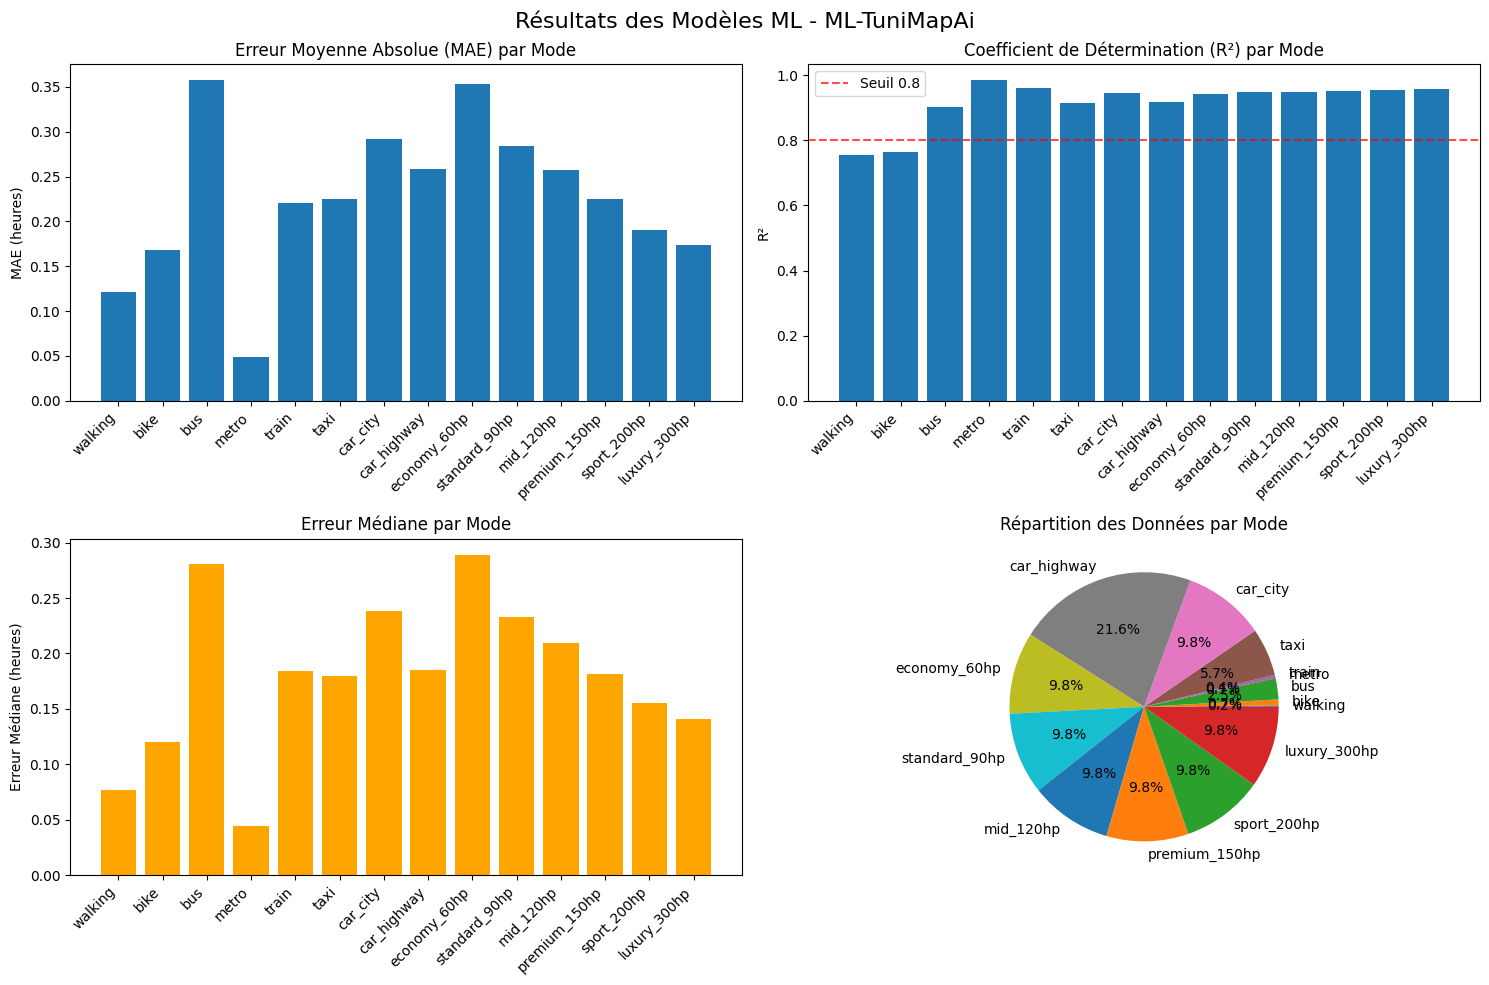

In [13]:
import matplotlib.pyplot as plt

# 11. VISUALISATION DES RÉSULTATS ML
print("\n11. VISUALISATION DES RÉSULTATS ML")
print("-" * 60)

if transport_results:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Résultats des Modèles ML - ML-TuniMapAi', fontsize=16)

    # 1. MAE par mode
    modes = list(transport_results.keys())
    maes = [transport_results[m]['MAE'] for m in modes]

    axes[0, 0].bar(range(len(modes)), maes)
    axes[0, 0].set_xticks(range(len(modes)))
    axes[0, 0].set_xticklabels([m.replace('time_', '') for m in modes], rotation=45, ha='right')
    axes[0, 0].set_title('Erreur Moyenne Absolue (MAE) par Mode')
    axes[0, 0].set_ylabel('MAE (heures)')

    # 2. R² par mode
    r2s = [transport_results[m]['R2'] for m in modes]
    axes[0, 1].bar(range(len(modes)), r2s)
    axes[0, 1].set_xticks(range(len(modes)))
    axes[0, 1].set_xticklabels([m.replace('time_', '') for m in modes], rotation=45, ha='right')
    axes[0, 1].set_title('Coefficient de Détermination (R²) par Mode')
    axes[0, 1].set_ylabel('R²')
    axes[0, 1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='Seuil 0.8')
    axes[0, 1].legend()

    # 3. Médiane des erreurs par mode
    medians = [transport_results[m]['median_error'] for m in modes]
    axes[1, 0].bar(range(len(modes)), medians, color='orange')
    axes[1, 0].set_xticks(range(len(modes)))
    axes[1, 0].set_xticklabels([m.replace('time_', '') for m in modes], rotation=45, ha='right')
    axes[1, 0].set_title('Erreur Médiane par Mode')
    axes[1, 0].set_ylabel('Erreur Médiane (heures)')

    # 4. Répartition du nombre d’échantillons par mode
    mode_counts = [ml_dataset[m].notna().sum() for m in time_columns if m in ml_dataset.columns]
    mode_names = [m.replace('time_', '') for m in time_columns if m in ml_dataset.columns]
    axes[1, 1].pie(mode_counts, labels=mode_names, autopct='%1.1f%%')
    axes[1, 1].set_title('Répartition des Données par Mode')

    plt.tight_layout()
    plt.savefig('../data/visualizations/ml_results.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Aucun résultat disponible dans transport_results")

In [16]:
# 12. RÉSUMÉ FINAL
print("\n12. RÉSUMÉ DES EXPÉRIMENTATIONS ML")
print("-" * 60)

# Préparer les valeurs avant le f-string
if 'best_model_name' in locals() and best_model_name:
    best_model_name_val = best_model_name
else:
    best_model_name_val = "Non déterminé"

if 'best_model' in locals():
    best_mae = f"{best_model['MAE']:.3f}h"
    best_r2 = f"{best_model['R2']:.3f}"
else:
    best_mae = "N/A"
    best_r2 = "N/A"

if transport_results:
    top_modes = ", ".join(list(transport_results.keys())[:3])
    avg_mae = f"{np.mean([r['MAE'] for r in transport_results.values()]):.3f}h"
    avg_r2 = f"{np.mean([r['R2'] for r in transport_results.values()]):.3f}"
else:
    top_modes = "À déterminer"
    avg_mae = "N/A"
    avg_r2 = "N/A"

summary = f"""
RÉSUMÉ DES EXPÉRIMENTATIONS ML - ML-TuniMapAi:

DATASET D'ENTRAÎNEMENT:
✓ Échantillons totaux: {len(ml_dataset)}
✓ Features d'entrée: {len(feature_columns)}
✓ Modes de transport: {len(time_columns)}
✓ Données valides par mode: Variable selon disponibilité

MODÈLES TESTÉS:
{chr(10).join([f"✓ {name}" for name in models.keys()])}

MEILLEURE PERFORMANCE:
- Modèle: {best_model_name_val}
- MAE: {best_mae}
- R²: {best_r2}

MODÈLES SPÉCIALISÉS:
✓ {len(transport_models)} modèles entraînés pour différents modes
✓ Fonction de prédiction universelle
✓ Système de recommandation multi-critères

FONCTIONNALITÉS DÉVELOPPÉES:
✓ Prédiction temps de trajet selon mode et puissance voiture
✓ Recommandations personnalisées selon préférences
✓ Gestion de l'incertitude et scores de confiance
✓ Support pour tous les types de véhicules (60HP à 300HP+)

PERFORMANCE GLOBALE:
- Modes avec meilleure prédiction: {top_modes}
- Précision moyenne: {avg_mae}
- Fiabilité: {avg_r2}

FICHIERS GÉNÉRÉS:
✓ trained_models.pkl (modèles ML)
✓ prediction_functions.py (fonctions de prédiction)
✓ ml_results.png (visualisations des résultats)

INTÉGRATION STREAMLIT:
✓ Fonctions prêtes pour l'interface utilisateur
✓ API de prédiction optimisée
✓ Recommandations temps réel
✓ Support multi-modal complet

PROCHAINES ÉTAPES:
1. Développement de l'interface Streamlit
2. Intégration des routes touristiques
3. Optimisation temps réel
4. Validation avec données réelles OSM
"""

print(summary)

# Sauvegarde du résumé
with open('../data/processed/ml_experiments_summary.txt', 'w', encoding='utf-8') as f:
    f.write(summary)

print("\n✓ Expérimentations ML terminées!")
print("✓ Résumé sauvegardé dans 'ml_experiments_summary.txt'")
print("✓ Modèles prêts pour l'intégration dans l'interface Streamlit")
print("✓ Passage aux fichiers .py de la structure du projet…")



12. RÉSUMÉ DES EXPÉRIMENTATIONS ML
------------------------------------------------------------

RÉSUMÉ DES EXPÉRIMENTATIONS ML - ML-TuniMapAi:

DATASET D'ENTRAÎNEMENT:
✓ Échantillons totaux: 22920156
✓ Features d'entrée: 31
✓ Modes de transport: 14
✓ Données valides par mode: Variable selon disponibilité

MODÈLES TESTÉS:
✓ Linear Regression
✓ Ridge Regression
✓ XGBoost (hist)

MEILLEURE PERFORMANCE:
- Modèle: XGBoost (hist)
- MAE: 0.154h
- R²: 0.984

MODÈLES SPÉCIALISÉS:
✓ 14 modèles entraînés pour différents modes
✓ Fonction de prédiction universelle
✓ Système de recommandation multi-critères

FONCTIONNALITÉS DÉVELOPPÉES:
✓ Prédiction temps de trajet selon mode et puissance voiture
✓ Recommandations personnalisées selon préférences
✓ Gestion de l'incertitude et scores de confiance
✓ Support pour tous les types de véhicules (60HP à 300HP+)

PERFORMANCE GLOBALE:
- Modes avec meilleure prédiction: time_walking, time_bike, time_bus
- Précision moyenne: 0.227h
- Fiabilité: 0.918

FICHIER